In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import librosa 
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, concatenate, Conv2D,UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.losses import mean_squared_error
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from tqdm import tqdm
from PIL import Image
import IPython.display as ipd
from scipy.ndimage import zoom
import gc

## Import Dataset

In [4]:
target = pd.read_csv('./dataset/class-target-v2.csv')

In [5]:
target.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
target['song_id'] = target['song_id'].astype(int)

In [7]:
target

song_id  min_arousal  max_arousal  min_valence  max_valence  frustrated  \
0           2         2.37         3.63         2.16         4.04    0.000000   
1           3         1.68         4.92         1.75         5.25    0.000000   
2           4         3.87         7.13         4.28         7.12    2.799620   
3           5         3.45         7.15         2.39         6.41   22.188046   
4           7         4.71         8.09         4.33         7.27    2.258685   
...       ...          ...          ...          ...          ...         ...   
1797     2054         2.24         4.96         4.20         6.60    0.000000   
1798     2055         3.73         6.67         3.59         6.41   11.989796   
1799     2056         2.86         6.34         3.59         6.41   10.104345   
1800     2057         6.46         7.20         2.10         4.24   50.000000   
1801     2058         4.63         6.97         3.05         4.55   51.282051   

          tense    excited      happy    content       calm      tired  \
0      0.000000   0.000000   0.000000   0.000000   0.000000  55.319149   
1      0.000000   0.000000   0.000000   0.127425   7.015432  48.549824   
2     13.764797  24.500994  24.272012  18.978981   6.895900   5.988076   
3     15.538860  13.698064   6.683138   6.683138   8.010286   8.076173   
4     18.575152  44.658958  25.927324   6.201445   0.423157   0.423157   
...         ...        ...        ...        ...        ...        ...   
1797   0.000000   0.000000   0.000000  18.639706  48.026961  28.909314   
1798  16.411565  16.411565  11.989796  11.871593   9.727047   9.727047   
1799   9.148529   9.148529  10.104345  10.129310  20.617816  20.617816   
1800  50.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1801  32.905983   0.000000   0.000000   0.000000   0.000000   0.000000   

      depressed  
0     44.680851  
1     44.307319  
2      2.799620  
3     19.122294  
4      1.532122  
...         ...  
1797   4.424020  
1798  11.871593  
1799  10.129310  
1800   0.000000  
1801  15.811966  

[1802 rows x 13 columns]

In [8]:
song_id_mapping = {song_id: i for i, song_id in enumerate(target['song_id'].unique())}

In [9]:
def play_audio(track):
    return ipd.Audio(f'./dataset/MEMD_audio/{track}.mp3')    

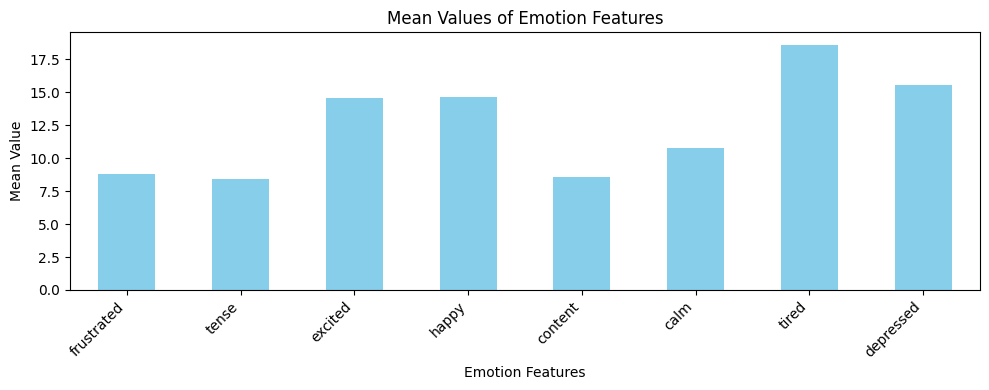

In [157]:
means = target[labels].mean()
plt.figure(figsize=(10, 4))
means.plot(kind='bar', color='skyblue')
plt.title('Mean Values of Emotion Features')
plt.xlabel('Emotion Features')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### Loading Audio 

In [12]:
audio_directory = './dataset/MEMD_audio/'

start_number = 1
end_number = 2058

audio_dict = {}

for file_number in tqdm(range(start_number, end_number + 1), desc="Processing audio files"):
    audio_path = f'{audio_directory}{file_number}.mp3'

    try:
        y, sr = librosa.load(audio_path, sr=20000, duration=25.0)  # Set duration to 30 seconds
        audio_dict[file_number] = (y, sr)

    except FileNotFoundError:
        continue

Processing audio files:   0%|                                                                 | 0/2058 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_21944\142974482.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=20000, duration=25.0)  # Set duration to 30 seconds
c:\python39\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing audio files:   0%|                                                         | 4/2058 [00:03<22:37,  1.51it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_21944\142974482.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=20000, duration=25.0)  # Set duration to 30 seconds
c:\python39\lib\site-packages\librosa\core\audio.py:183: FutureWarning: l

### Volume Plot

In [140]:
def generate_volume_plots(audio_dict, n1, n2, n3, n4):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    sub_dict = {n1: audio_dict.get(n1),
                n2: audio_dict.get(n2),
                n3: audio_dict.get(n3),
                n4: audio_dict.get(n4)}

    for i, (key, (amplitude_array, sample_rate)) in enumerate(sub_dict.items()):
        time = np.arange(0, len(amplitude_array)) / sample_rate
        axs[i].plot(time, amplitude_array, label=f'Song {key}')
        axs[i].set_title(f'Song {key}')
        axs[i].set_xlabel('Time (seconds)')
        axs[i].set_ylabel('Amplitude')
        axs[i].grid(True)
        axs[i].legend()

    plt.suptitle('Volume Plots of Songs')
    plt.tight_layout()
    plt.show()

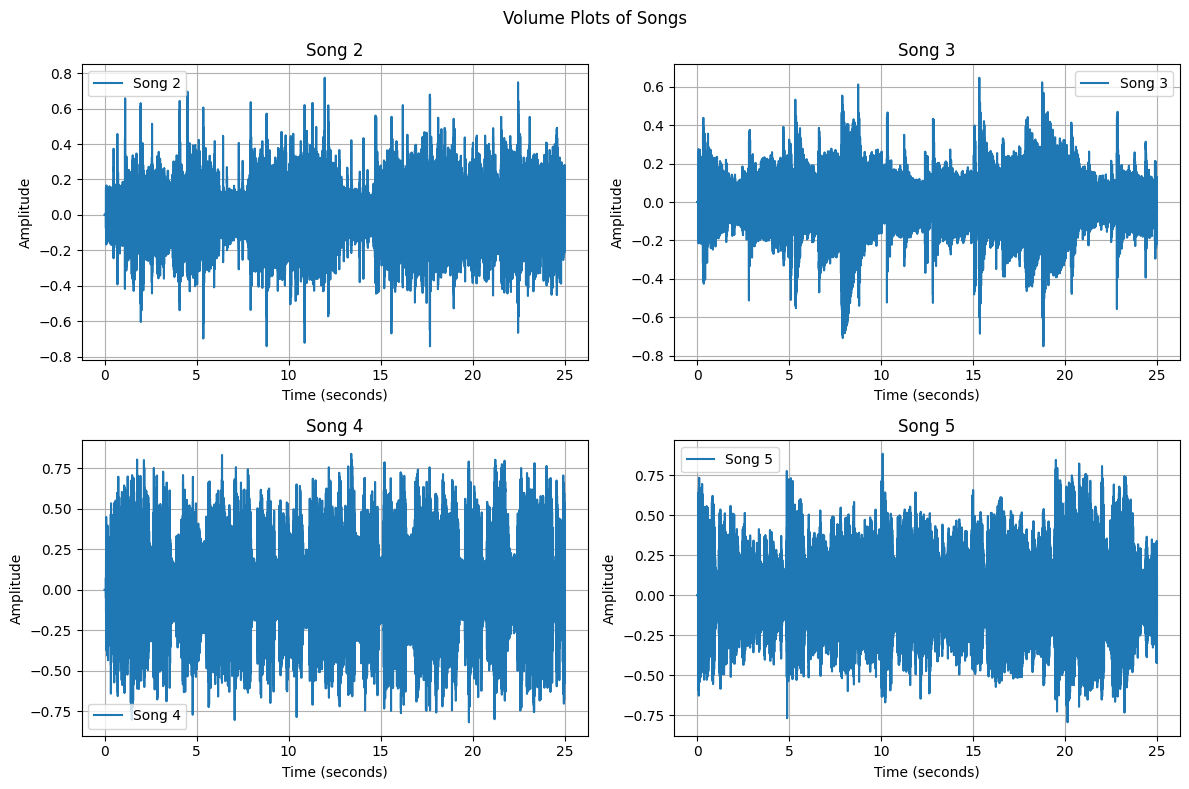

In [141]:
generate_volume_plots(audio_dict, 2,3,4,5)

### Spectograms

In [145]:
def generate_spectrogram_plots(audio_dict, n1, n2, n3, n4):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    sub_dict = {n1: audio_dict.get(n1),
                n2: audio_dict.get(n2),
                n3: audio_dict.get(n3),
                n4: audio_dict.get(n4)}

    for i, (key, (amplitude_array, sample_rate)) in enumerate(sub_dict.items()):
        time = np.arange(0, len(amplitude_array)) / sample_rate
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(amplitude_array)), ref=np.max)
        
        librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[i], cmap='viridis')
        axs[i].set_title(f'Song {key}')
        axs[i].set_xlabel('Time (seconds)')
        axs[i].set_ylabel('Frequency (Hz)')

    plt.suptitle('Spectrogram Plots of Songs')
    plt.tight_layout()
    plt.show()

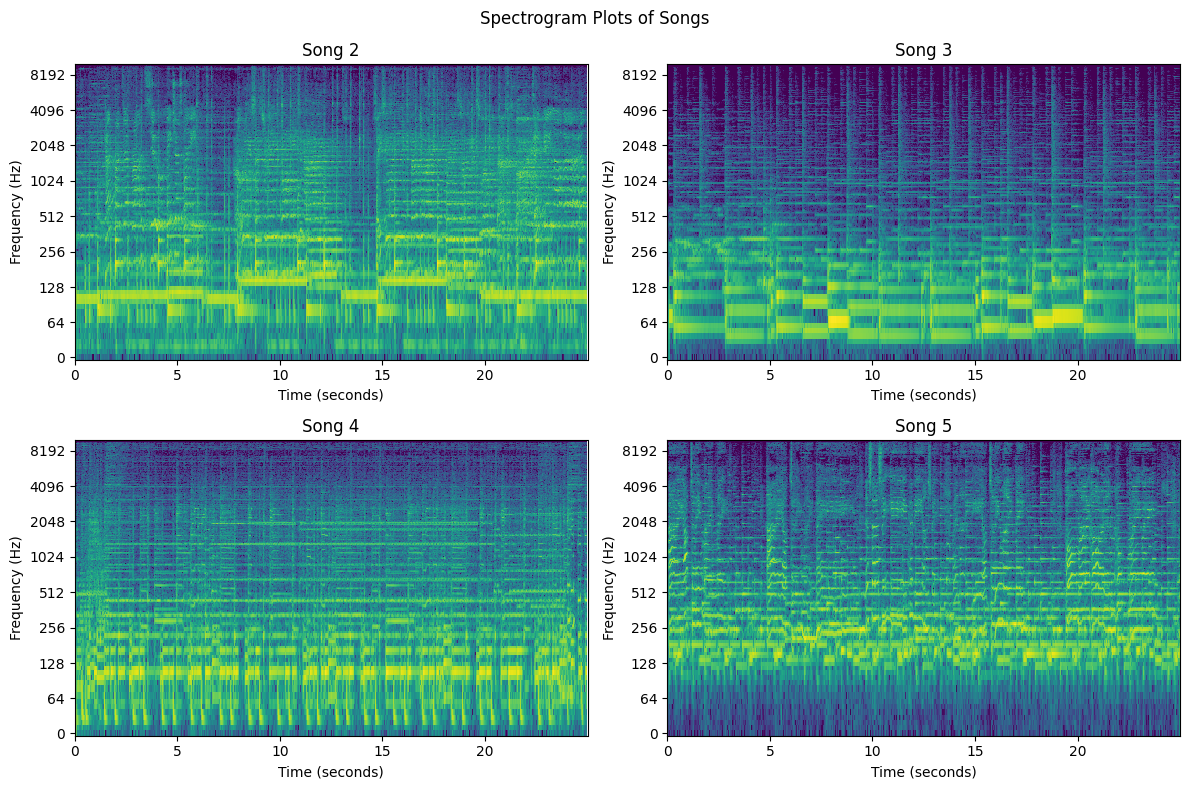

In [146]:
generate_spectrogram_plots(audio_dict, 2,3,4,5)

#### Importing Spectograms

In [54]:
image_folder = './log_spectrogram_plots/'

image_paths = []
emotion_percentages = []

for _, row in target.iterrows():
    song_id = row['song_id'].astype(int)
    image_path = os.path.join(image_folder, f'log_spectrogram_{song_id}.png')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        emotion_percentages.append(row.values[5:])  # Exclude 'song_id' column and min max values

emotion_percentages = np.array(emotion_percentages)

In [13]:
X_train_path, X_val_path, y_train, y_val = train_test_split(image_paths, emotion_percentages, test_size=0.2, random_state=42)

In [14]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(160, 400))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalization
    return img_array

### Full Images

In [ ]:
X_train = np.array([preprocess_image(img_path) for img_path in X_train_path])
X_val = np.array([preprocess_image(img_path) for img_path in X_val_path])

In [21]:
height = X_train[0].shape[0]
width = X_train[0].shape[1]

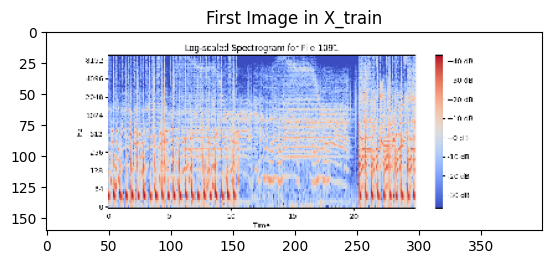

In [22]:
plt.imshow(X_train[0])
plt.title('First Image in X_train')
plt.show()

### Cropped Images

In [48]:
def crop_and_resize_image(image_path, crop_box):
    img = Image.open(image_path)
    cropped_img = img.crop(crop_box)

    return cropped_img

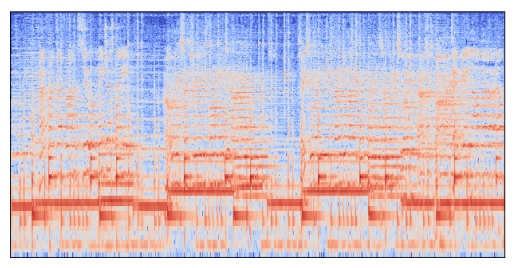

In [16]:
crop_box = (125, 45, 747, 357)

height = 312
width = 622

image_path = "./log_spectrogram_plots/log_spectrogram_2.png"
cropped_and_resized_img = crop_and_resize_image(image_path, crop_box)

plt.imshow(cropped_and_resized_img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [17]:
crop_box = (125, 45, 747, 357)

X_train_cropped = [crop_and_resize_image(img_path, crop_box) for img_path in X_train_path]
X_val_cropped = [crop_and_resize_image(img_path, crop_box) for img_path in X_val_path]

In [18]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalization
        processed_images.append(img_array)
    return processed_images

In [19]:
X_train_processed = preprocess_images(X_train_cropped)
X_val_processed = preprocess_images(X_val_cropped)

In [20]:
img_to_array(X_train_processed[0]).shape

(312, 622, 4)

In [21]:
cropped_height = X_val_processed[0].shape[0]
cropped_width = X_val_processed[0].shape[1]

### Training

In [22]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))
lr_scheduler = LearningRateScheduler(lr_schedule)

In [25]:
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(cropped_height, cropped_width, 4)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')  
])

In [26]:
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])  
cnn_model.fit(np.array(X_train_processed), y_train, epochs=5, batch_size=32, validation_data=(np.array(X_val_processed), y_val), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 275s 6s/step - loss: 270.1973 - mae: 12.0065 - val_loss: 197.7986 - val_mae: 10.3496 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 209s 5s/step - loss: 200.7554 - mae: 10.4732 - val_loss: 206.0013 - val_mae: 9.8809 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 201s 4s/step - loss: 213.3469 - mae: 10.8245 - val_loss: 194.4688 - val_mae: 10.4851 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 207s 4s/step - loss: 200.1077 - mae: 10.3973 - val_loss: 220.3159 - val_mae: 11.1788 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 198s 4s/step - loss: 193.5786 - mae: 10.1898 - val_loss: 199.2103 - val_mae: 10.3467 - lr: 0.0010


In [43]:
predictions = model.predict(np.array(X_val_processed))

12/12 [==============================] - 8s 632ms/step


In [69]:
predictions[song_id_mapping[10]]

array([55.391144  ,  0.7310781 ,  0.6746334 ,  2.4744782 ,  2.2379036 ,
        0.53744185,  7.63373   , 10.308908  ,  7.089367  , 10.62123   ,
        5.1045046 ,  1.822031  ,  2.3886082 ], dtype=float32)

In [70]:
target[target['song_id'] == 10]

song_id  neutral_percentage  excited_percentage  delighted_percentage  \
6       10           48.956142                 0.0                   0.0   

   happy_percentage  content_percentage  relaxed_percentage  calm_percentage  \
6               0.0                 0.0                 0.0         7.100664   

   tired_percentage  bored_percentage  depressed_percentage  \
6          7.586179          5.583428              9.305713   

   frustrated_percentage  angry_percentage  tense_percentage  
6               9.305713          3.350057          4.551707

In [71]:
play_audio(10)

In [120]:
gc.collect()

20038

## Mel Spectogram 

In [154]:
def generate_mel_spectrogram_plots(audio_dict, n1, n2, n3, n4):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    sub_dict = {n1: audio_dict.get(n1),
                n2: audio_dict.get(n2),
                n3: audio_dict.get(n3),
                n4: audio_dict.get(n4)}

    for i, (key, (amplitude_array, sample_rate)) in enumerate(sub_dict.items()):
        mel_spectrogram = librosa.feature.melspectrogram(y=amplitude_array, sr=sample_rate)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=axs[i], cmap='plasma')
        axs[i].set_title(f'Song {key}')
        axs[i].set_xlabel('Time (seconds)')
        axs[i].set_ylabel('Mel Frequency')
        axs[i].grid(True)

    plt.suptitle('Mel Spectrogram Plots of Songs')
    plt.tight_layout()
    plt.show()

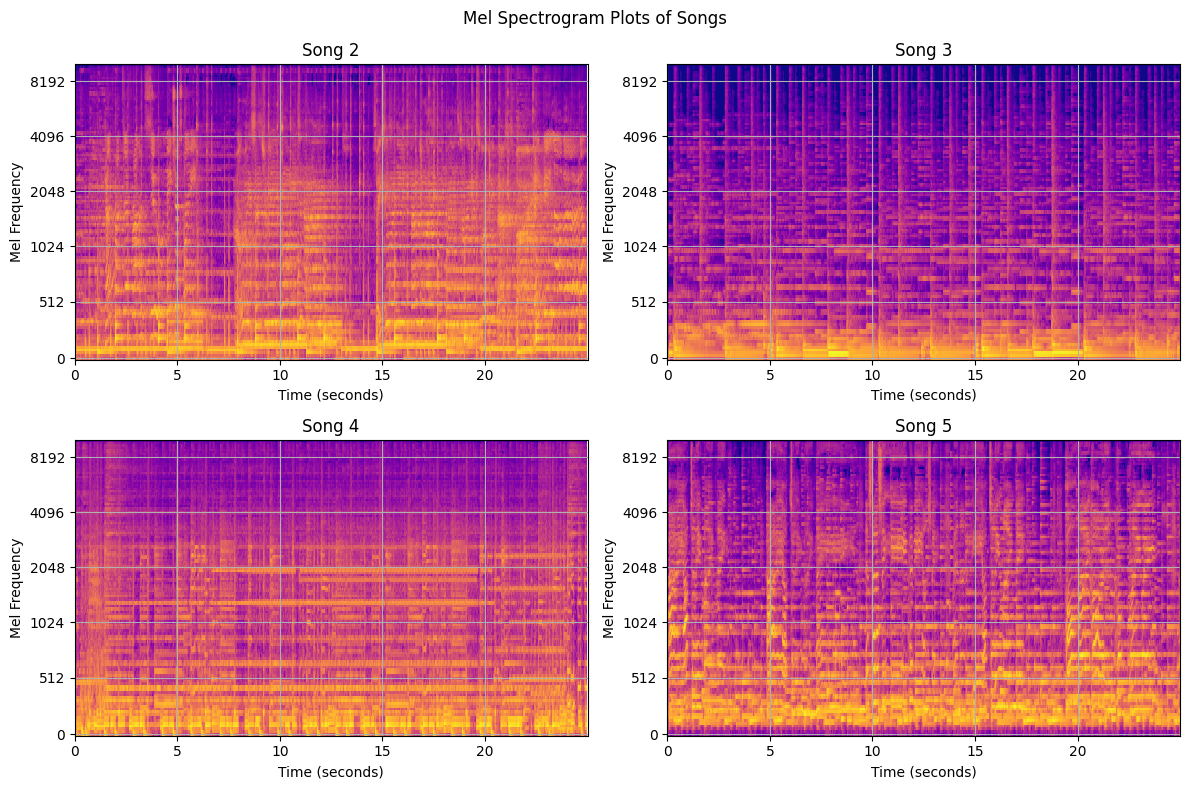

In [155]:
generate_mel_spectrogram_plots(audio_dict, 2,3,4,5)

### Mel Spectograms (Arrays)

In [13]:
output_directory = 'mel-spectogram'

In [14]:
for file_number, (y, sr) in tqdm(list(audio_dict.items()), desc="Generating Mel Spectrograms for First 10"):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    output_path = f'./{output_directory}/mel_spectrogram_{file_number}.npy'
    np.save(output_path, mel_spectrogram_db)

Generating Mel Spectrograms for First 10: 100%|████████████████████████████████████| 1802/1802 [00:48<00:00, 37.21it/s]


In [15]:
def plot_mel(file_number):
    array_path = f'./{output_directory}/mel_spectrogram_{file_number}.npy'
    mel_spectrogram_db = np.load(array_path)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, y_axis='mel', fmax=8000, x_axis='time')
    plt.title(f'Mel Spectrogram - File {file_number}')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

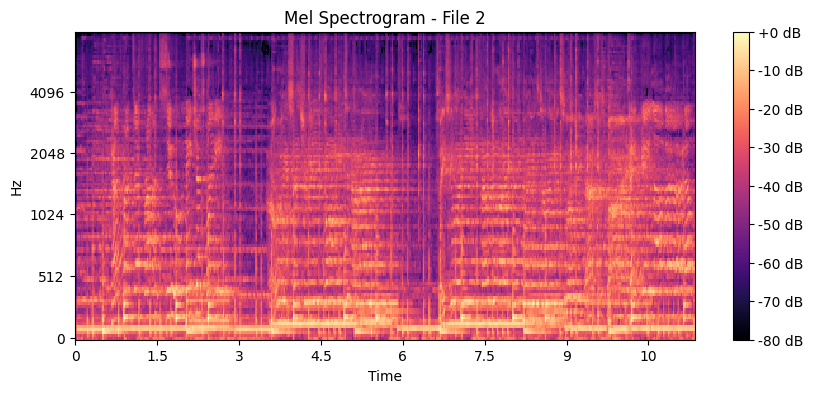

In [16]:
plot_mel(2)

In [17]:
mel_spectrogram_db.shape

(128, 489)

In [159]:
mel_spectrograms = []

for file_number in tqdm(range(1, 2058 + 1), desc="Loading Mel Spectrograms"):
    array_path = f'./{output_directory}/mel_spectrogram_{file_number}.npy'
    
    if os.path.exists(array_path):
        mel_spectrogram_db = np.load(array_path)
        mel_spectrograms.append(mel_spectrogram_db)

mel_spectrograms = np.array(mel_spectrograms)

Loading Mel Spectrograms: 100%|████████████████████████████████████████████████████| 2058/2058 [00:26<00:00, 76.68it/s]


In [160]:
mel_spectrograms.shape

(1802, 128, 489)

In [161]:
mel_spectrograms_reshaped = mel_spectrograms.reshape((mel_spectrograms.shape[0], mel_spectrograms.shape[1], mel_spectrograms.shape[2], 1))

In [162]:
mel_spectrograms_reshaped.shape

(1802, 128, 489, 1)

In [163]:
X_mel_train, X_mel_val, y_train, y_val = train_test_split(mel_spectrograms_reshaped, emotion_percentages, test_size=0.2, random_state=42)

### CNN

In [164]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))
lr_scheduler = LearningRateScheduler(lr_schedule)

In [23]:
emotion_percentages.shape

(1802, 8)

In [ ]:
cnn_model_mel = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')  # Linear activation for regression
])

In [93]:
cnn_model_mel.compile(optimizer='adam', loss='mse', metrics=['mae'])  
cnn_model_mel.fit(X_mel_train, y_train, epochs=5, batch_size=32, validation_data=(X_mel_val, y_val), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 77s 2s/step - loss: 7151.6768 - mae: 24.0823 - val_loss: 234.7833 - val_mae: 11.5514 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 52s 1s/step - loss: 247.5298 - mae: 12.0553 - val_loss: 233.7805 - val_mae: 11.8237 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 55s 1s/step - loss: 249.4831 - mae: 12.0400 - val_loss: 234.4758 - val_mae: 11.7869 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 57s 1s/step - loss: 244.5689 - mae: 11.9663 - val_loss: 236.7234 - val_mae: 11.9810 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 55s 1s/step - loss: 239.0656 - mae: 11.8149 - val_loss: 235.6848 - val_mae: 11.0876 - lr: 0.0010


### Simpler CNN

In [138]:
cnn_model_mel_simple = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')
])

cnn_model_mel_simple.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
cnn_model_mel_simple.fit(X_mel_train, y_train, epochs=5, batch_size=32, validation_data=(X_mel_val, y_val), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 42s 898ms/step - loss: 37564.0508 - mae: 55.8511 - val_loss: 240.0233 - val_mae: 11.8690 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 48s 1s/step - loss: 244.3327 - mae: 12.0238 - val_loss: 229.6282 - val_mae: 11.8223 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 48s 1s/step - loss: 226.8271 - mae: 11.5084 - val_loss: 220.1839 - val_mae: 11.2470 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 49s 1s/step - loss: 211.5740 - mae: 11.0082 - val_loss: 206.7454 - val_mae: 10.9009 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 54s 1s/step - loss: 190.6159 - mae: 10.3494 - val_loss: 205.5719 - val_mae: 10.8633 - lr: 0.0010


### Scaling 

In [165]:
scaler = MinMaxScaler()
X_mel_train_normalized = scaler.fit_transform(X_mel_train.reshape(-1, 1)).reshape(X_mel_train.shape)
X_mel_val_normalized = scaler.transform(X_mel_val.reshape(-1, 1)).reshape(X_mel_val.shape)

In [29]:
cnn_model_mel_simple = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')
])

cnn_model_mel_simple.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
cnn_model_mel_simple.fit(X_mel_train_normalized, y_train, epochs=5, batch_size=32, validation_data=(X_mel_val_normalized, y_val), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 42s 903ms/step - loss: 228.1656 - mae: 11.1022 - val_loss: 214.7955 - val_mae: 10.9798 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 51s 1s/step - loss: 196.3629 - mae: 10.2520 - val_loss: 189.8554 - val_mae: 10.1813 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 50s 1s/step - loss: 184.3336 - mae: 9.9798 - val_loss: 186.7402 - val_mae: 9.8205 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 49s 1s/step - loss: 179.2294 - mae: 9.7567 - val_loss: 197.5099 - val_mae: 10.0654 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 52s 1s/step - loss: 160.5424 - mae: 9.3195 - val_loss: 185.2598 - val_mae: 9.3652 - lr: 0.0010


In [170]:
y_pred = cnn_model_mel_simple.predict(X_mel_val_normalized)

12/12 [==============================] - 7s 541ms/step


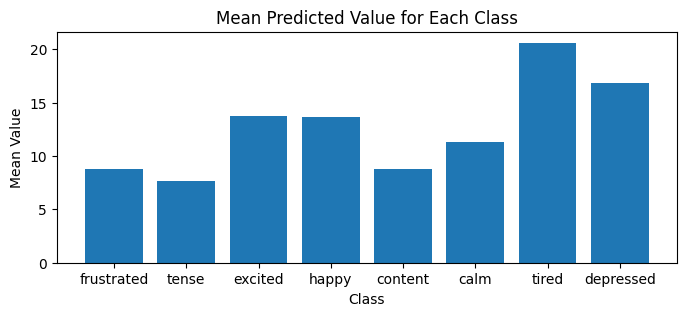

In [176]:
column_means = np.mean(y_pred, axis=0)

plt.figure(figsize=(8, 3))
plt.bar(labels, column_means)
plt.xlabel('Class')
plt.ylabel('Mean Value')
plt.title('Mean Predicted Value for Each Class')
plt.show()

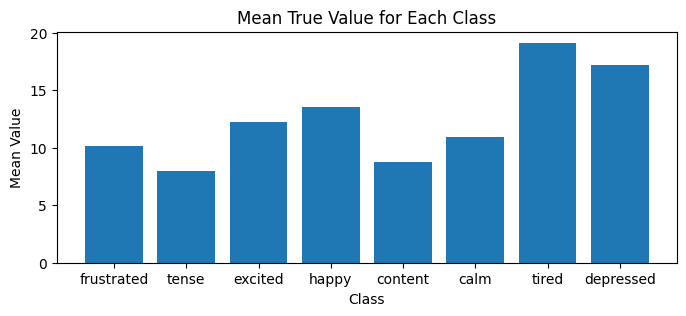

In [177]:
column_means = np.mean(y_val, axis=0)

plt.figure(figsize=(8, 3))
plt.bar(labels, column_means)
plt.xlabel('Class')
plt.ylabel('Mean Value')
plt.title('Mean True Value for Each Class')
plt.show()

### CNN-RNN

In [30]:
cnn_rnn_model_mel = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Reshape((-1, 128)),
    
    layers.Bidirectional(layers.LSTM(128, activation='relu', return_sequences=True)),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')  
])

cnn_rnn_model_mel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
cnn_rnn_model_mel.fit(X_mel_train_normalized, y_train, epochs=5, batch_size=32, validation_data=(X_mel_val_normalized, y_val), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 882s 19s/step - loss: 223.5017 - mae: 11.0414 - val_loss: 198.7715 - val_mae: 10.4222 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 1004s 22s/step - loss: 195.8465 - mae: 10.2352 - val_loss: 191.5117 - val_mae: 10.1827 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 1823s 40s/step - loss: 187.5080 - mae: 9.9726 - val_loss: 257.1608 - val_mae: 11.8270 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 573s 12s/step - loss: 192.8808 - mae: 10.1477 - val_loss: 199.4615 - val_mae: 10.1832 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 602s 13s/step - loss: 188.1379 - mae: 9.9935 - val_loss: 184.1163 - val_mae: 9.7653 - lr: 0.0010


Add Early stopping and dropout layer to prevent overfitting

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_rnn_model_mel_v2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Reshape((-1, 128)),
    
    layers.Bidirectional(layers.LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    layers.Dropout(0.5),  
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5), 
    
    layers.Dense(8, activation='linear')  
])

cnn_rnn_model_mel_v2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
cnn_rnn_model_mel_v2.fit(X_mel_train_normalized, y_train, epochs=20, batch_size=32, validation_data=(X_mel_val_normalized, y_val), callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
46/46 [==============================] - 514s 11s/step - loss: 255.0801 - mae: 11.4034 - val_loss: 209.6022 - val_mae: 9.9180 - lr: 0.0010
Epoch 2/20
46/46 [==============================] - 561s 12s/step - loss: 224.6332 - mae: 10.6422 - val_loss: 215.2216 - val_mae: 10.8333 - lr: 0.0010
Epoch 3/20
46/46 [==============================] - 539s 12s/step - loss: 216.1054 - mae: 10.4880 - val_loss: 196.0063 - val_mae: 9.6519 - lr: 0.0010
Epoch 4/20
46/46 [==============================] - 564s 12s/step - loss: 212.1407 - mae: 10.3455 - val_loss: 194.1782 - val_mae: 10.1701 - lr: 0.0010
Epoch 5/20
46/46 [==============================] - 528s 12s/step - loss: 208.4339 - mae: 10.2296 - val_loss: 198.0238 - val_mae: 9.9774 - lr: 0.0010
Epoch 6/20
46/46 [==============================] - 609s 13s/step - loss: 208.5344 - mae: 10.2765 - val_loss: 193.7427 - val_mae: 9.6039 - lr: 0.0010
Epoch 7/20
46/46 [==============================] - 608s 13s/step - loss: 212.3961 - mae: 10.3733 

In [53]:
gc.collect()

505

### Mel Spectograms (Images)

In [ ]:
save_directory = './log_mel_spectrogram_plots/'

for file_number, Y_log_scale in tqdm(Y_log_scale_dict.items(), desc='Plotting and Saving Log-scaled Spectrograms', unit='file', leave=False):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Y_log_scale, sr=sr, hop_length=HOP_SIZE, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-scaled Spectrogram for File {file_number}')
    
    # Save the plot
    save_path = f'{save_directory}log_spectrogram_{file_number}.png'
    plt.savefig(save_path)
    del save_path
    plt.clf()
    plt.close('all')
    gc.collect()

In [119]:
output_directory = './log_mel_spectrogram_plots/'

for file_number, (y, sr) in tqdm(list(audio_dict.items()), desc="Plotting and Saving Mel Spectrograms"):
   # Generate mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, y_axis='mel', fmax=8000, x_axis='time')
    plt.title(f'Mel Spectrogram - File {file_number}')
    plt.colorbar(format='%+2.0f dB')

    # Save the plot as an image file
    output_plot_path = os.path.join(output_directory, f'mel_spectrogram_plot_{file_number}.png')
    plt.savefig(output_plot_path, bbox_inches='tight')

    plt.close()
    plt.clf()
    gc.collect()

Plotting and Saving Mel Spectrograms: 100%|██████████████████████████████████████| 1802/1802 [1:01:09<00:00,  2.04s/it]


<Figure size 640x480 with 0 Axes>

In [41]:
def plot_img(img):
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

In [42]:
crop_box = (75, 30, 697, 341)

In [49]:
X_mel = []
output_directory = './log_mel_spectrogram_plots/'

for file_number, (y, sr) in tqdm(list(audio_dict.items()), desc="Loading and Preprocessing Images"):
    image_path = os.path.join(output_directory, f'mel_spectrogram_plot_{file_number}.png')
    
    if os.path.exists(image_path):
        processed_image = crop_and_resize_image(image_path, crop_box)
        image_array = np.array(processed_image)

        X_mel.append(image_array)

Loading and Preprocessing Images: 100%|████████████████████████████████████████████| 1802/1802 [00:38<00:00, 46.98it/s]


In [50]:
X_mel_np = np.array(X_mel)

In [51]:
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(X_mel_np, emotion_percentages, test_size=0.2, random_state=42)

In [52]:
X_train_mel_preprocessed = X_train_mel / 255.0
X_test_mel_preprocessed = X_test_mel / 255.0

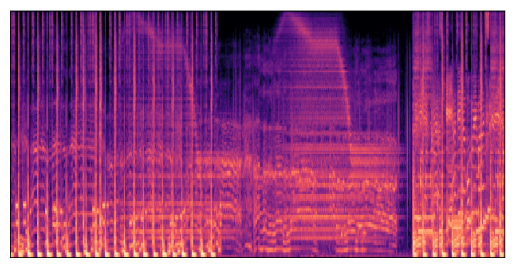

In [54]:
plot_img(X_train_mel[0])

### CNN

In [55]:
input_shape_mel = X_train_mel[0].shape

In [133]:
cnn_model_mel2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_mel),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')  
])

In [135]:
cnn_model_mel2.compile(optimizer='adam', loss='mse', metrics=['mae'])  
cnn_model_mel2.fit(X_train_mel, y_train_mel, epochs=5, batch_size=32, validation_data=(X_test_mel, y_test_mel), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 189s 4s/step - loss: 1101181.3750 - mae: 196.0097 - val_loss: 234.1077 - val_mae: 11.2415 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 191s 4s/step - loss: 206.6280 - mae: 10.6631 - val_loss: 246.1496 - val_mae: 11.8525 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 193s 4s/step - loss: 214.0285 - mae: 10.7570 - val_loss: 193.7991 - val_mae: 10.2049 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 188s 4s/step - loss: 191.5895 - mae: 10.1439 - val_loss: 190.8935 - val_mae: 10.1623 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 197s 4s/step - loss: 191.7567 - mae: 10.1653 - val_loss: 194.9429 - val_mae: 10.2185 - lr: 0.0010


With normalization

In [56]:
cnn_model_mel3 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_mel),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='linear')  
])

In [58]:
cnn_model_mel3.compile(optimizer='adam', loss='mse', metrics=['mae'])  
cnn_model_mel3.fit(X_train_mel_preprocessed, y_train_mel, epochs=5, batch_size=32, validation_data=(X_test_mel_preprocessed, y_test_mel), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 335s 7s/step - loss: 267.6303 - mae: 11.8058 - val_loss: 193.8725 - val_mae: 10.2085 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 312s 7s/step - loss: 201.4235 - mae: 10.5158 - val_loss: 203.9301 - val_mae: 10.2150 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 305s 7s/step - loss: 195.2722 - mae: 10.2036 - val_loss: 187.9328 - val_mae: 10.0609 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 305s 7s/step - loss: 196.6397 - mae: 10.3352 - val_loss: 212.4147 - val_mae: 10.1534 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 304s 7s/step - loss: 198.6421 - mae: 10.3700 - val_loss: 199.6598 - val_mae: 10.3735 - lr: 0.0010


### Categorical Labels - Multiple

In [22]:
target

song_id  min_arousal  max_arousal  min_valence  max_valence  frustrated  \
0           2         2.37         3.63         2.16         4.04    0.000000   
1           3         1.68         4.92         1.75         5.25    0.000000   
2           4         3.87         7.13         4.28         7.12    2.799620   
3           5         3.45         7.15         2.39         6.41   22.188046   
4           7         4.71         8.09         4.33         7.27    2.258685   
...       ...          ...          ...          ...          ...         ...   
1797     2054         2.24         4.96         4.20         6.60    0.000000   
1798     2055         3.73         6.67         3.59         6.41   11.989796   
1799     2056         2.86         6.34         3.59         6.41   10.104345   
1800     2057         6.46         7.20         2.10         4.24   50.000000   
1801     2058         4.63         6.97         3.05         4.55   51.282051   

          tense    excited      happy    content       calm      tired  \
0      0.000000   0.000000   0.000000   0.000000   0.000000  55.319149   
1      0.000000   0.000000   0.000000   0.127425   7.015432  48.549824   
2     13.764797  24.500994  24.272012  18.978981   6.895900   5.988076   
3     15.538860  13.698064   6.683138   6.683138   8.010286   8.076173   
4     18.575152  44.658958  25.927324   6.201445   0.423157   0.423157   
...         ...        ...        ...        ...        ...        ...   
1797   0.000000   0.000000   0.000000  18.639706  48.026961  28.909314   
1798  16.411565  16.411565  11.989796  11.871593   9.727047   9.727047   
1799   9.148529   9.148529  10.104345  10.129310  20.617816  20.617816   
1800  50.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1801  32.905983   0.000000   0.000000   0.000000   0.000000   0.000000   

      depressed  
0     44.680851  
1     44.307319  
2      2.799620  
3     19.122294  
4      1.532122  
...         ...  
1797   4.424020  
1798  11.871593  
1799  10.129310  
1800   0.000000  
1801  15.811966  

[1802 rows x 13 columns]

In [23]:
labels = ['frustrated', 'tense', 'excited', 'happy', 'content', 'calm', 'tired', 'depressed']

In [24]:
threshold = 13
target_binary = target[labels].applymap(lambda x: 1 if x > threshold else 0)
target_binary['song_id'] = target['song_id'] 

In [25]:
target_binary

frustrated  tense  excited  happy  content  calm  tired  depressed  \
0              0      0        0      0        0     0      1          1   
1              0      0        0      0        0     0      1          1   
2              0      1        1      1        1     0      0          0   
3              1      1        1      0        0     0      0          1   
4              0      1        1      1        0     0      0          0   
...          ...    ...      ...    ...      ...   ...    ...        ...   
1797           0      0        0      0        1     1      1          0   
1798           0      1        1      0        0     0      0          0   
1799           0      0        0      0        0     1      1          0   
1800           1      1        0      0        0     0      0          0   
1801           1      1        0      0        0     0      0          1   

      song_id  
0           2  
1           3  
2           4  
3           5  
4           7  
...       ...  
1797     2054  
1798     2055  
1799     2056  
1800     2057  
1801     2058  

[1802 rows x 9 columns]

In [26]:
y_cat = target_binary.drop(columns=['song_id'])

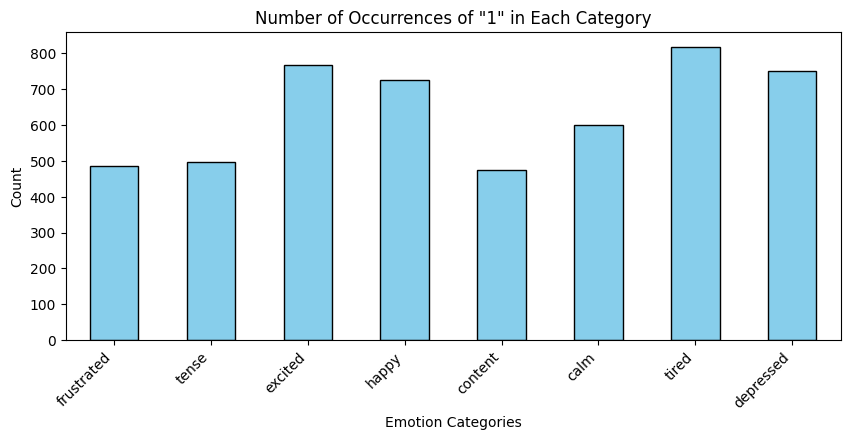

In [27]:
counts = y_cat.sum()

plt.figure(figsize=(10, 4))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Occurrences of "1" in Each Category')
plt.xlabel('Emotion Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [28]:
X_cat_train, X_cat_val, y_cat_train, y_cat_val = train_test_split(mel_spectrograms_reshaped, y_cat, test_size=0.2, random_state=42)

In [29]:
scaler = MinMaxScaler()
X_cat_train_normalized = scaler.fit_transform(X_cat_train.reshape(-1, 1)).reshape(X_cat_train.shape)
X_cat_val_normalized = scaler.transform(X_cat_val.reshape(-1, 1)).reshape(X_cat_val.shape)

In [30]:
y_cat

frustrated  tense  excited  happy  content  calm  tired  depressed
0              0      0        0      0        0     0      1          1
1              0      0        0      0        0     0      1          1
2              0      1        1      1        1     0      0          0
3              1      1        1      0        0     0      0          1
4              0      1        1      1        0     0      0          0
...          ...    ...      ...    ...      ...   ...    ...        ...
1797           0      0        0      0        1     1      1          0
1798           0      1        1      0        0     0      0          0
1799           0      0        0      0        0     1      1          0
1800           1      1        0      0        0     0      0          0
1801           1      1        0      0        0     0      0          1

[1802 rows x 8 columns]

In [31]:
X_cat_train.shape

(1441, 128, 489, 1)

In [186]:
cnn_model_mel_multi_label = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='sigmoid')  
])
        
        
cnn_model_mel_multi_label.compile(optimizer='adam', loss='binary_crossentropy')

f1_callback = F1Callback()
cnn_model_mel_multi_label.fit(X_cat_train_normalized, y_cat_train, epochs=5, batch_size=32, validation_data=(X_cat_val_normalized, y_cat_val), callbacks=[lr_scheduler])

Epoch 1/5
46/46 [==============================] - 43s 915ms/step - loss: 0.8138 - val_loss: 0.5815 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 48s 1s/step - loss: 0.5729 - val_loss: 0.5652 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 50s 1s/step - loss: 0.5404 - val_loss: 0.5871 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 48s 1s/step - loss: 0.4998 - val_loss: 0.5882 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 55s 1s/step - loss: 0.4263 - val_loss: 0.6158 - lr: 0.0010


Add dropout and early stopping to prevent overfitting

In [33]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))
lr_scheduler = LearningRateScheduler(lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_model_mel_multi_label = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='sigmoid')  
])

cnn_model_mel_multi_label.compile(optimizer='adam', loss='binary_crossentropy')
cnn_model_mel_multi_label.fit(X_cat_train_normalized, y_cat_train, epochs=5, batch_size=32, 
                               validation_data=(X_cat_val_normalized, y_cat_val), 
                               callbacks=[lr_scheduler, early_stopping])


Epoch 1/5
46/46 [==============================] - 55s 1s/step - loss: 1.0792 - val_loss: 0.6238 - lr: 0.0010
Epoch 2/5
46/46 [==============================] - 58s 1s/step - loss: 0.6002 - val_loss: 0.5920 - lr: 0.0010
Epoch 3/5
46/46 [==============================] - 60s 1s/step - loss: 0.5891 - val_loss: 0.5918 - lr: 0.0010
Epoch 4/5
46/46 [==============================] - 59s 1s/step - loss: 0.5644 - val_loss: 0.5677 - lr: 0.0010
Epoch 5/5
46/46 [==============================] - 59s 1s/step - loss: 0.5588 - val_loss: 0.5882 - lr: 0.0010


In [48]:
threshold_values = np.arange(0.1, 1.0, 0.1)

best_f1_score = 0
best_threshold = 0

for threshold in threshold_values:
    y_pred = (y_pred_probs >= threshold).astype(int)
    f1 = f1_score(y_cat_val_np, y_pred, average='micro')

    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

Best Threshold: 0.4
Best F1 Score: 0.5879282218597064


In [180]:
y_pred_probs = cnn_model_mel_multi_label.predict(X_cat_val_normalized)

threshold = 0.4
y_pred = (y_pred_probs >= threshold).astype(int)

y_cat_val_np = y_cat_val.to_numpy()
y_pred_np = y_pred

12/12 [==============================] - 7s 532ms/step


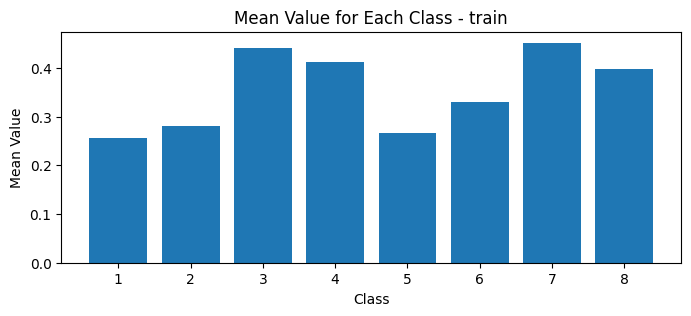

In [37]:
column_means = np.mean(y_cat_train, axis=0)

plt.figure(figsize=(8,3))
plt.bar(range(1, 9), column_means)
plt.xlabel('Class')
plt.ylabel('Mean Value')
plt.title('Mean Value for Each Class - train')
plt.show()

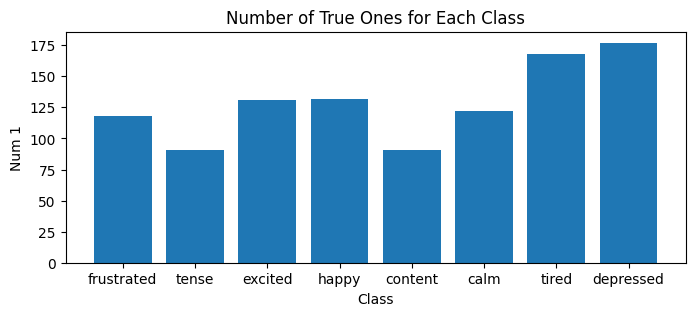

In [185]:
column_counts = np.sum(y_cat_val_np, axis=0)

plt.figure(figsize=(8, 3))
plt.bar(labels, column_counts)
plt.xlabel('Class')
plt.ylabel('Num 1')
plt.title('Number of True Ones for Each Class')
plt.show()

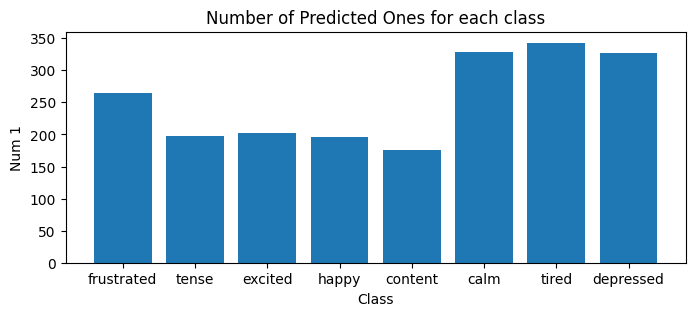

In [184]:
column_counts = np.sum(y_pred_np, axis=0)

plt.figure(figsize=(8,3))
plt.bar(labels, column_counts)
plt.xlabel('Class')
plt.ylabel('Num 1')
plt.title('Number of Predicted Ones for each class')
plt.show()

In [80]:
class_names = labels
report = classification_report(y_cat_val_np, y_pred_np, target_names=class_names)

In [81]:
print(report)

              precision    recall  f1-score   support

  frustrated       0.34      0.76      0.47       118
       tense       0.39      0.85      0.53        91
     excited       0.58      0.90      0.71       131
       happy       0.57      0.84      0.68       132
     content       0.36      0.70      0.48        91
        calm       0.34      0.91      0.49       122
       tired       0.48      0.98      0.64       168
   depressed       0.51      0.94      0.66       177

   micro avg       0.44      0.87      0.59      1030
   macro avg       0.45      0.86      0.58      1030
weighted avg       0.46      0.87      0.60      1030
 samples avg       0.49      0.88      0.60      1030



In [149]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_rnn_model_mel = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Reshape((-1, 128)),
    
    layers.Bidirectional(layers.LSTM(128, activation='relu', return_sequences=True)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='sigmoid')  
])

cnn_rnn_model_mel.compile(optimizer='adam', loss='binary_crossentropy')
cnn_rnn_model_mel.fit(X_cat_train_normalized, y_cat_train, epochs=3, batch_size=32, validation_data=(X_cat_val_normalized, y_cat_val), callbacks=[lr_scheduler, early_stopping])

Epoch 1/3
26/46 [===============>..............] - ETA: 13:23 - loss: 0.5137

KeyboardInterrupt: 

In [ ]:
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))
lr_scheduler = LearningRateScheduler(lr_schedule)


cnn_model_mel_multi_label = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 489, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='sigmoid')  
])

cnn_model_mel_multi_label.compile(optimizer='adam', loss='binary_crossentropy')
cnn_model_mel_multi_label.fit(X_cat_train_normalized, y_cat_train, epochs=5, batch_size=32, 
                               validation_data=(X_cat_val_normalized, y_cat_val), 
                               callbacks=[lr_scheduler, early_stopping])
